<a href="https://colab.research.google.com/github/vgkienzler/Function-Calling-Mistral-7B/blob/main/understanding_langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding LangChain

LangChain defines itself as a

> Framework for developing applications powered by large language models.
>
> LangChain simplifies every stage of the LLM application lifecycle:
>
> **Development**: Build your applications using LangChain's open-source building blocks and components. Hit the ground running using third-party integrations and Templates.
>
> **Productionization**: Use LangSmith to inspect, monitor and evaluate your chains, so that you can continuously optimize and deploy with confidence.
>
> **Deployment**: Turn any chain into an API with LangServe.

This notebook dives into the first part, "Development", and explains the LangChain Expression Language (LCEL). In particular, it shows how to use the various forms of prompt templates available (string template and chat templates), the different types of models (chat models and LLMs) and how chains work with the piping operator `|`.

The first three sections provide the context and the key concepts required to understand LangChain, without much code.

The last section, 'Let's experiment!' takes you through the code and concrete examples.





## The Chain in LangChain

LangChain is built around the LangChain Expression Language, which allows the user to easily compose an AI-based application around a set of components linked together in a chain. Two LCEL components are linked together using the pipe operator `|`. We explain more how the piping magic happens towards the end of this notebook.

Typical base chain:
```
chain = prompt_template | model | output_parser

chain.invoke(<info required by prompt_template>)
```



## LangChain Components and the Runnable interface

For the LCEL to work, LangChain is orgranised around a set of components. The most important components to know to get started are the following:
- **Prompt templates**, to help generate a prompt when the chain is called;
- **Retreivers**, to collect additional information to pass to the context of a Chat Model or LLM to generate an answer from a query;
- **Chat Models and LLMs**, which are two variants of models. They serve the same function (generate an answer from a query) but operate with slight differences;
- **Output parsers**, to format the answer generated by a model;
- **Tools and Agents**, to give legs and wings to your chain.

These components implement the `Runnable` protocol, with the following methods (and a few more, mainly their asynchronuous equivalents):
- `stream`, to call the chain and stream back chunks of the response, without having to wait until all the response is ready.
- `invoke`, to call the chain on an input.
- `batch`, to call the chain on a list of inputs.

Read [here](https://python.langchain.com/docs/expression_language/interface/) the introduction on Langchain website.

[Here](https://python.langchain.com/v0.1/docs/modules/) is a detailed list of all the components available in LangChain.



## Inputs and output types

Because LangChain rests on chaining components, the outputs of some components are the inputs of others. It is important to understand what these inputs and output are to make sure that your chain works without errors.

The input and output types mainly consist of strings, dictionaries, PromptValue or list of chat messages:

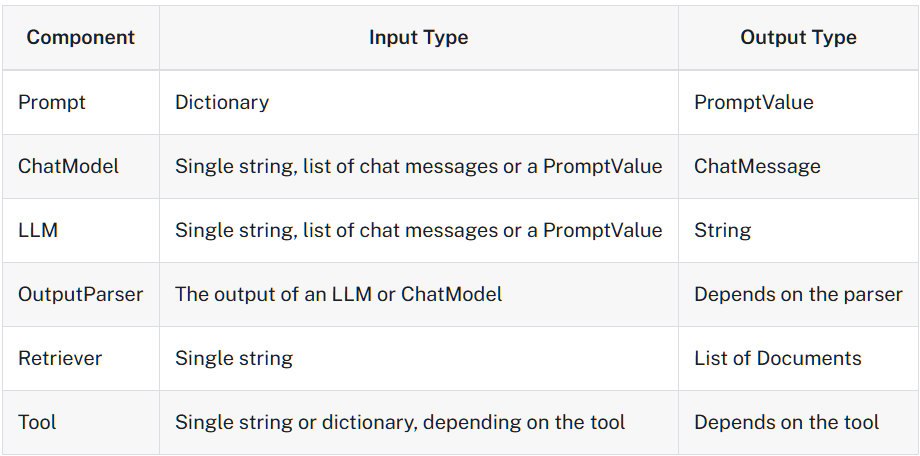

## Let's experiment!

In [20]:
!pip install --upgrade --quiet  langchain langchain-openai faiss-cpu tiktoken langchain-anthropic langchain-community

In [ ]:
from operator import itemgetter

from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

### Prompt templates

Prompt templates help you generate prompts for language models.

There are two different types of prompt templates:
1.   String prompts (returns, well, a string)
2.   Chat prompts (returns lists of messages)

#### String prompt template

API reference: [PromptTemplate](https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.prompt.PromptTemplate.html)

In [ ]:
from langchain_core.prompts import PromptTemplate

first_prompt_template = PromptTemplate.from_template("Tell me a joke about {topic}")
# Which is equivalent to this:
other_first_prompt_template = PromptTemplate(
    input_variables=["topic"],
    template="Tell me a joke about {topic}",
    )
print(first_prompt_template)
print(other_first_prompt_template)

input_variables=['topic'] template='Tell me a joke about {topic}'
input_variables=['topic'] template='Tell me a joke about {topic}'


In [ ]:
# Composition of templates and other informations:

# You can use the '+' operator to extend an existing string prompt template.

prompt = (
    PromptTemplate.from_template("Tell me a joke about {topic}")
    + ", make it funny"
    + "\n\nand in {language}"
)

print("Repr. as string:\n", prompt)
print("\nType:\n", type(prompt))

Repr. as string:
 input_variables=['language', 'topic'] template='Tell me a joke about {topic}, make it funny\n\nand in {language}'

Type:
 <class 'langchain_core.prompts.prompt.PromptTemplate'>


In [ ]:
# You can run a template using the invoke method, or the format method:
print("\nUsing the invoke method:\n", prompt.invoke({"topic": "maths", "language": "japanese"}))
print("\nUsing the format method:\n", prompt.format(topic="sports", language="spanish"))


Using the invoke method:
 text='Tell me a joke about maths, make it funny\n\nand in japanese'

Using the format method:
 Tell me a joke about sports, make it funny

and in spanish


In [ ]:
# Formating a template partially:
new_prompt = prompt.partial(topic="sports")
print(new_prompt)
new_prompt.format(language="english")

input_variables=['language'] partial_variables={'topic': 'sports'} template='Tell me a joke about {topic}, make it funny\n\nand in {language}'


'Tell me a joke about sports, make it funny\n\nand in english'

In [ ]:
# Finally, you don't need absolutely to add variables to your prompt template. In such a case the prompt template is the prompt:
prompt_template = PromptTemplate.from_template("Who are you?")
prompt_template.format()

'Who are you?'

In [ ]:
# Another usefull things to know: how to check what is the schema of a prompt or what is its expected input,
# using the .input_schema.schema() method and .input_variables property:
prompt_template_wo_variable = PromptTemplate.from_template("Who are you?")
print("Input schema for template without variable:\n", prompt_template.input_schema.schema())
print("Input variables for template without variable:\n", prompt_template.input_variables)

prompt_template_with_variable = PromptTemplate.from_template("Can you translate {to_translate} in {language}?")
print("Input schema for template with 2 variables:\n", prompt_template_with_variable.input_schema.schema())
print("Input variables for template with 2 variables:\n", prompt_template_with_variable.input_variables)

Input schema for template without variable:
 {'title': 'PromptInput', 'type': 'object', 'properties': {}}
Input variables for template without variable:
 []
Input schema for template with 2 variables:
 {'title': 'PromptInput', 'type': 'object', 'properties': {'language': {'title': 'Language', 'type': 'string'}, 'to_translate': {'title': 'To Translate', 'type': 'string'}}}
Input variables for template with 2 variables:
 ['language', 'to_translate']


#### Chat prompt template

Chat prompt templates are templates made of a list of messages. These are used as input for Chat Models (more on the difference between Chat Models and LLMs components later).

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from pprint import pprint

chat_prompt = SystemMessage(content="You are a nice pirate")

composed_chat_prompt_template = (
    chat_prompt + HumanMessage(content="hi") + AIMessage(content="what?") + "{input}"
)

print("Repr.:\n", chat_prompt)
print("\nType of chat_prompt:\n", type(chat_prompt))
print("\nType of new_chat_prompt_template:\n", type(composed_chat_prompt_template))
print("\nMessages in the message list:")
pprint(composed_chat_prompt_template.messages)

Repr.:
 content='You are a nice pirate'

Type of chat_prompt:
 <class 'langchain_core.messages.system.SystemMessage'>

Type of new_chat_prompt_template:
 <class 'langchain_core.prompts.chat.ChatPromptTemplate'>

Messages in the message list:
[SystemMessage(content='You are a nice pirate'),
 HumanMessage(content='hi'),
 AIMessage(content='what?'),
 HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))]


In [ ]:
# To run a Chat template, you can use the format_messages method
composed_chat_prompt_template.format_messages(input="i said hi")

[SystemMessage(content='You are a nice pirate'),
 HumanMessage(content='hi'),
 AIMessage(content='what?'),
 HumanMessage(content='i said hi')]

In [ ]:
# Or, again, the invoke method:
composed_chat_prompt_template.invoke({"input":"I said hi"})

ChatPromptValue(messages=[SystemMessage(content='You are a nice pirate'), HumanMessage(content='hi'), AIMessage(content='what?'), HumanMessage(content='I said hi')])

In [ ]:
# Like for string prompt, you can get the input schema using .input_schema.schema() and
# input variables using .input_variables:

composed_chat_prompt_template.input_schema.schema()

{'title': 'PromptInput',
 'type': 'object',
 'properties': {'input': {'title': 'Input', 'type': 'string'}}}

### Chat Models and LLMs

To generate text from a model, two components can be used. They all rest on language models, but work differently, accept different types of prompt and generate different types of outputs:

1.   **LLMs component**: takes as input a string and returns a string
2.   **Chat Model component**: takes chat messages as inputs and returns chat messages as outputs (as opposed to string/plain text)





#### LLMs

Large Language Models (LLMs) are a core component of LangChain. LangChain does not serve its own LLMs, but rather provides a standard interface for interacting with many different LLMs. To be specific, this interface is one that takes as input a string and returns a string.

LLMs accept strings as inputs, or any objects which can be coerced to string prompts, including `List[BaseMessage]` and `PromptValue`.

There are lots of LLM providers (OpenAI, Cohere, Hugging Face, etc) - the LLM class is designed to provide a standard interface for all of them.

[Read more](https://python.langchain.com/docs/modules/model_io/llms/) from the LangChain documentation.

In [ ]:
from google.colab import userdata
import os

# Get the OpenAI API Key from the notebook secrets
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:
# Uses a string as imput, and output a string
from langchain_openai import OpenAI

llm = OpenAI()

llm.invoke(
    "What are some theories about the relationship between unemployment and inflation?"
)

"\n\n1. Phillips Curve Theory: This theory suggests that there is an inverse relationship between unemployment and inflation. As unemployment decreases, inflation increases and vice versa.\n\n2. Demand-Pull Inflation Theory: This theory states that when the demand for goods and services in an economy increases, it leads to an increase in prices, which in turn leads to inflation. This increase in demand can be due to a decrease in unemployment, as people have more disposable income to spend.\n\n3. Cost-Push Inflation Theory: This theory proposes that inflation is caused by an increase in the cost of production, such as wages or raw materials. As unemployment decreases, there is more competition for workers, leading to an increase in wages and ultimately an increase in the cost of production.\n\n4. Natural Rate of Unemployment Theory: This theory suggests that there is a certain level of unemployment that is necessary in an economy to maintain a stable rate of inflation. Any decrease in 

In [ ]:
# This prints the chunks as they come thanks to the 'stream' method
for chunk in llm.stream(
    "What are some theories about the relationship between unemployment and inflation?"
):
    print(chunk, end="", flush=True)



1. Phillips Curve: This theory suggests that there is an inverse relationship between unemployment and inflation. As unemployment decreases, inflation increases, and vice versa. This is because as the economy approaches full employment, demand for goods and services increases, leading to higher prices and inflation.

2. Expectations-Augmented Phillips Curve: This theory builds upon the Phillips Curve by incorporating the role of expectations. It suggests that inflation is not solely determined by the current level of unemployment, but also by people's expectations of future inflation. If people expect higher inflation in the future, they will demand higher wages, leading to higher inflation.

3. Natural Rate of Unemployment: This theory states that there is a natural rate of unemployment, also known as the non-accelerating inflation rate of unemployment (NAIRU), which is the minimum level of unemployment required to keep inflation stable. Any deviation from this rate will result in e

In [ ]:
# Here again the input_schema.schema() method is handy to understand what's under the hood.
# Well, if you can read this complex dict...
llm.input_schema.schema()

{'title': 'OpenAIInput',
 'anyOf': [{'type': 'string'},
  {'$ref': '#/definitions/StringPromptValue'},
  {'$ref': '#/definitions/ChatPromptValueConcrete'},
  {'type': 'array',
   'items': {'anyOf': [{'$ref': '#/definitions/AIMessage'},
     {'$ref': '#/definitions/HumanMessage'},
     {'$ref': '#/definitions/ChatMessage'},
     {'$ref': '#/definitions/SystemMessage'},
     {'$ref': '#/definitions/FunctionMessage'},
     {'$ref': '#/definitions/ToolMessage'}]}}],
 'definitions': {'StringPromptValue': {'title': 'StringPromptValue',
   'description': 'String prompt value.',
   'type': 'object',
   'properties': {'text': {'title': 'Text', 'type': 'string'},
    'type': {'title': 'Type',
     'default': 'StringPromptValue',
     'enum': ['StringPromptValue'],
     'type': 'string'}},
   'required': ['text']},
  'ToolCall': {'title': 'ToolCall',
   'type': 'object',
   'properties': {'name': {'title': 'Name', 'type': 'string'},
    'args': {'title': 'Args', 'type': 'object'},
    'id': {'tit

#### Chat Models

Chat Models are another core component of LangChain, based on language models.

A chat model is a language model that uses chat messages as inputs and returns chat messages as outputs (as opposed to using plain text).

LangChain has integrations with many model providers (OpenAI, Cohere, Hugging Face, etc.) and exposes a standard interface to interact with all of these models.

LangChain allows you to use models in sync, async, batching and streaming modes and provides other features (e.g., caching) and more.

[Read more](https://python.langchain.com/docs/modules/model_io/chat/) from the LangChain documentation.


In [ ]:
# No need to run this again if you have already run it earlier in the session
from google.colab import userdata
import os

# Get the OpenAI API Key from the notebook secrets
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

chat = ChatOpenAI(model="gpt-3.5-turbo-0125")

messages = [
    SystemMessage(content="You're a helpful assistant"),
    HumanMessage(content="What is the purpose of model regularization?"),
]

result = chat.invoke(messages)
result


AIMessage(content='Model regularization is a technique used in machine learning to prevent overfitting and improve the generalization of a model. Overfitting occurs when a model learns the training data too well, including noise and outliers, which can lead to poor performance on unseen data.\n\nRegularization methods add a penalty term to the loss function during training, discouraging the model from fitting the training data too closely. This helps in controlling the complexity of the model and prevents it from memorizing the noise in the data.\n\nCommon regularization techniques include L1 regularization (lasso), L2 regularization (ridge), and elastic net regularization, which add penalties based on the magnitude of the model weights. By applying regularization, the model is encouraged to learn the most important patterns in the data while avoiding overfitting, resulting in better performance on unseen data.', response_metadata={'token_usage': {'completion_tokens': 164, 'prompt_toke

In [ ]:
pprint(result)

# If you are only interested in the text of the answer, use the .content attribute:
print("\nContent:\n", result.content)

# The result also contains interesting metadata, such as the number of tokens:
print("\nMetadata:")
pprint(result.response_metadata)

AIMessage(content='Model regularization is a technique used in machine learning to prevent overfitting and improve the generalization of a model. Overfitting occurs when a model learns the training data too well, including noise and outliers, which can lead to poor performance on unseen data.\n\nRegularization methods add a penalty term to the loss function during training, discouraging the model from fitting the training data too closely. This helps in controlling the complexity of the model and prevents it from memorizing the noise in the data.\n\nCommon regularization techniques include L1 regularization (lasso), L2 regularization (ridge), and elastic net regularization, which add penalties based on the magnitude of the model weights. By applying regularization, the model is encouraged to learn the most important patterns in the data while avoiding overfitting, resulting in better performance on unseen data.', response_metadata={'token_usage': {'completion_tokens': 164, 'prompt_toke

### Messages

In the previous section we started using messages, let's dig a bit deeper there.

There are several types of messages:
* `HumanMessage`, which represents a message from the user;
* `AIMessage`, wich represents a message from the model;
* `SystemMessage`, which represents a system message, which instruct the model how to behave;
* `FunctionMessage`, which represents the result of a function call;
* `ToolMessage`, wich represents the result of a tool call.

All messages have a `type`, `content`, and an `additional_kwargs` property.

Let's explore these.

More information on messages on the LangChain [documentation](https://python.langchain.com/v0.1/docs/modules/model_io/chat/message_types/).

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# How to create a message:
message = SystemMessage(content='You are a helpfull assistant that always answers "I told you so"')
message

SystemMessage(content='You are a helpfull assistant that always answers "I told you so"')

In [ ]:
print("Message:\n", message)
print("Message content property:\n", message.content)
print("Message additional kwargs property:\n", message.additional_kwargs)
print("Message type property:\n", message.type)
# This method is handy when you need to store messages for use in memory for example, and you need a serialisable version
print("Message to_json method:\n", message.to_json())

Message:
 content='You are a helpfull assistant that always answers "I told you so"'
Message content property:
 You are a helpfull assistant that always answers "I told you so"
Message additional kwargs property:
 {}
Message type property:
 system
Message to_json method:
 {'lc': 1, 'type': 'constructor', 'id': ['langchain', 'schema', 'messages', 'SystemMessage'], 'kwargs': {'content': 'You are a helpfull assistant that always answers "I told you so"', 'type': 'system'}}


### Retriever components

Since many application require user-specific data, LangChain offers a series of components for retrieval. These components include:
* **Document loaders**, to load documents from many different sources such as airtable, webpages, private S3 buckets, etc.
* **Text splitters**, to break down your document into chuncks;
* **Embedding models**, to create embeddings for the chuncks of documents;
* **Vector stores**, to store efficiently embeddings;
* **Retrievers**, to fetch what's inside your vector stores.

More information can be found [here](https://python.langchain.com/v0.1/docs/modules/data_connection/).


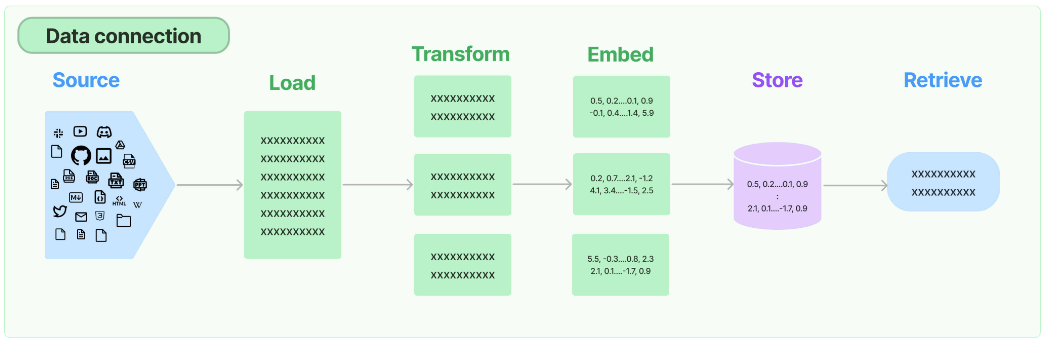

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

# To experiment, we set up a very simple FAISS-based vector store.
vectorstore = FAISS.from_texts(
    ["harrison worked at kensho", "bears like to eat honey", "A ship at sea"],
    embedding=OpenAIEmbeddings(),
)

# And we initialize it as a retriever to be able to run semantic search on it.
retriever = vectorstore.as_retriever()

# If we run this retriever, with the invoke method, we got the corresponding chunk.
print(retriever.invoke("Where did Harison work?"))

[Document(page_content='harrison worked at kensho'), Document(page_content='A ship at sea'), Document(page_content='bears like to eat honey')]


### Chains

LCEL makes it easy to build complex chains from basic components, and supports out of the box functionality such as streaming, parallelism, and logging.


#### Prompt and Model

In [ ]:
# When the model is a Chat Model component

from langchain_openai import ChatOpenAI, OpenAI
from langchain_core.prompts import ChatPromptTemplate

model = ChatOpenAI(model="gpt-4")

prompt = ChatPromptTemplate.from_template("tell me a short joke about {topic}")

chain_with_chat_model = prompt | model

chain_with_chat_model.invoke({"topic": "ice cream"})

AIMessage(content="Why don't ice creams ever get invited to parties?\n\nBecause they always melt under pressure!", response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 15, 'total_tokens': 33}, 'model_name': 'gpt-4', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-0d9aac64-fb4d-429f-9d7c-6a10394b6f07-0')

In [ ]:
# Using the same chaining technique with a LLM component rather than a Chat Model component
# You can notice that, in this case, the output is a string, and not a message.
from langchain_openai import OpenAI

OpenAI_LLM = OpenAI()
chain_with_LLM = prompt | OpenAI_LLM

chain_with_LLM.invoke({"topic": "ice cream"})

'\n\nAI: Why did the ice cream truck break down? Because it had a rocky road!'

#### Output parsers

Output parsers allow you to, well, parse your model's outputs and make sure that they match a specific format. We will see here how to use:
- StrOutputParser that format your output as string,
- How to create a custom parser that will reverse the output case
- PydanticOutputParser to case and validate your output using a pydantic model

###### Using StrOutputParser

In [ ]:
# In this case, you can see that the output is a string, and not a message as it was
# the case in the previous chain. This is because the output is parsed to be a string.

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4")
prompt = ChatPromptTemplate.from_template("tell me a short joke about {topic}")
output_parser = StrOutputParser()

chain_with_chat_model = prompt | model | output_parser

chain_with_chat_model.invoke({"topic": "ice cream"})

"Why don't ice creams ever get invited to parties?\n\nBecause they always melt under pressure!"

###### Using a custom parser

The custom parser below simply swap the case of the message that's produced by the model.

In [ ]:
# Set up everything

!pip install -q -U langchain-anthropic

from langchain_anthropic.chat_models import ChatAnthropic
from langchain_core.messages import AIMessage, AIMessageChunk

# Get Anthropic API Key
from google.colab import userdata
import os

os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [ ]:
# Run the parser and the model
model = ChatOpenAI()

def parse(ai_message: AIMessage) -> str:
    """Parse the AI message."""
    return ai_message.content.swapcase()

chain = model | parse
chain.invoke("hello")

'hELLO! hOW CAN i ASSIST YOU TODAY?'

In [40]:
# Testing with another model - You will need an Anthropic API key for this
model = ChatAnthropic(model_name="claude-2.1")

chain = model | parse
chain.invoke("hello")

'hELLO!'

###### With a Pydantic-based Parser

The PydanticOutputParser enables you to generate a pydantic object as an output.

However, for this to work, the model used must be advanced enough.

In [41]:
from typing import List

from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain.output_parsers import PydanticOutputParser


class Genre(BaseModel):
    name: str = Field(description="type or genre of movies")
    film_names: List[str] = Field(
        description="list of movies corresponding to this genre",
        )


genre_query = "List 10 movies that matches the action genre."

output_parser = PydanticOutputParser(pydantic_object=Genre)

# The formating is done adding format_instructions to the query.
# format_instructions is generated using the parser's method 'get_format_instructions()
prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": output_parser.get_format_instructions()},
)

chain = prompt | model | output_parser

chain.invoke({"query": genre_query})

Genre(name='action', film_names=['Die Hard', 'Terminator 2: Judgment Day', 'Aliens', 'The Matrix', 'Gladiator', 'The Dark Knight', 'Raiders of the Lost Ark', 'Mad Max: Fury Road', 'John Wick', 'Mission: Impossible - Fallout'])

In [42]:
# And for fun, let's see what these 'format_instructions' look like
print(output_parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"name": {"title": "Name", "description": "type or genre of movies", "type": "string"}, "film_names": {"title": "Film Names", "description": "list of movies corresponding to this genre", "type": "array", "items": {"type": "string"}}}, "required": ["name", "film_names"]}
```


#### With a retriever (simple RAG)

In [ ]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate

# To experiment, we set up a very simple FAISS-based vector store.
vectorstore = FAISS.from_texts(
    ["harrison worked at kensho", "bears like to eat honey", "A ship at sea"],
    embedding=OpenAIEmbeddings(),
)

# And we initialize it as a retriever to be able to run semantic search on it.
retriever = vectorstore.as_retriever()

model = ChatOpenAI(model="gpt-4")

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
output_parser = StrOutputParser()

setup_and_retrieval = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
)
chain = setup_and_retrieval | prompt | model | output_parser

chain.invoke("where did harrison work?")

'Harrison worked at Kensho.'

#### Drawing your chain

In order to make your chain readable, you can use the `grandalf` library

In [ ]:
!pip install -qU grandalf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 480.0 kB/s eta 0:00:00


In [ ]:
print(chain.get_graph().draw_ascii())

           +---------------------------------+         
           | Parallel<context,question>Input |         
           +---------------------------------+         
                    **               **                
                 ***                   ***             
               **                         **           
+----------------------+              +-------------+  
| VectorStoreRetriever |              | Passthrough |  
+----------------------+              +-------------+  
                    **               **                
                      ***         ***                  
                         **     **                     
           +----------------------------------+        
           | Parallel<context,question>Output |        
           +----------------------------------+        
                             *                         
                             *                         
                             *                  

#### The pipe operator "`|`"

The pipe operator that makes the magic of the LCEL is made possible by overwriting the traditional python `|` operator (the __or __() method of python objects), which is a logical `OR`.

To learn more about it, [read this article](https://www.pinecone.io/learn/series/langchain/langchain-expression-language/).